#Notice
I assume you use Tensorflow version 2.X.
You can use Google Colab to run this project.
https://colab.research.google.com/

#Dataset
First of all, we need the movie dataset. We can download it from the website https://grouplens.org/datasets/movielens/.

In the website there are many datasets, here I work with the one called "ml-1m.zip". Downlaod this dataset to your machine and unzip using the line below:

In [29]:
!unzip -o ml-1m.zip 

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


#Libraries
In the block below we download the libraries we need in the project.

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

#Read the data
We start check our data. This dataset has three files: movies, ratings and users. The data provided with extension ".dat" (i.e. the seprator is "::"). We will read all these three files and we start by reading movies.dat file, we can notice the columns we have are "MovieID::Title::Genres".

In [31]:
# MovieID::Title::Genres
df_movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', header=None)
df_movies.head(2)

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [32]:
# assign column names to the movies data
df_movies.columns = ['MovieID', 'Title', 'Genres']
df_movies.head(2)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [33]:
# how many movie we have
len(df_movies)

3883

In [34]:
# read the second data file "ratings.dat" and this includes:
# UserID::MovieID::Rating::Timestamp
df_ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', header=None)
df_ratings.head(2)

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109


In [35]:
# assign columns names to ratings data file
df_ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_ratings.head(2)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [36]:
# read the thrid data file "users" and this includes:
# UserID::Gender::Age::Occupation::Zip-code
df_users = pd.read_csv('ml-1m/users.dat', sep='::', engine='python', header=None)
df_users.head(2)

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072


In [37]:
# create pivot data frame from the ratings data
user_rating_df = df_ratings.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head(2)

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# how many moives we have in ratings file
n_Movies = len(user_rating_df.columns)
n_Movies

3706

In [39]:
# the unique values in Rating column in ratings.dat file
df_ratings['Rating'].unique()

array([5, 3, 4, 2, 1])

In [40]:
# replace the null values with 0 in rating file
# then divide by 5 to normlaise the ratings: 
# [1,.., 5] --> [0,..,1]
norm_user_rating_df = user_rating_df.fillna(0) / 5
trx = norm_user_rating_df.values
trx[:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
trx.shape

(6040, 3706)

#The RBM model
We use subclass model from Tensorflow 2 to create a custom Dense layer and then custom model.

In [42]:
# the RBM model parameters
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)

In [43]:
# custom Dense layer
class OurDenseLayer(tf.keras.layers.Layer):
  def __init__(self, n_output_nodes):
    super(OurDenseLayer, self).__init__()
    self.n_output_nodes = n_output_nodes

  def build(self, input_shape):
    d = int(input_shape[-1])
    # Define and initialize parameters: a weight matrix W and bias b
    # Note that parameter initialization is random!
    self.W = self.add_weight("weight", shape=[d, self.n_output_nodes]) # note the dimensionality
    self.b = self.add_weight("bias", shape=[1, self.n_output_nodes]) # note the dimensionality
    self.b2 = self.add_weight("bias2", shape=[1, d]) # note the dimensionality

  def call(self, x):
    z0 = tf.matmul(x, self.W)
    z = tf.add(z0, self.b)
    y = z
    return y

  def call2(self, x):
    z0 = tf.matmul(x, tf.transpose(self.W))
    z = tf.add(z0, self.b2)
    y = z
    return y

In [44]:
# custom model using the custom dense layer created in the previous block
class RBM(tf.keras.Model):
  def __init__(self, n_hidden_units):
    super(RBM, self).__init__()
    self.n_hidden_units = n_hidden_units
    self.Hidden = OurDenseLayer(self.n_hidden_units)
    self.Hidden.build((1,n_Movies))

  def call(self, input):
    #Phase 1: Input forwording
    x = self.Hidden.call(input)
    x = tf.nn.sigmoid(x)
    #Phase 2: Reconstruction
    x_rec = self.Hidden.call2(x)
    x_rec = tf.nn.sigmoid(x_rec)
    return x_rec



In [45]:
# one training loop function
@tf.function
def one_step_training(x):
  with tf.GradientTape() as tp:
    pred = RBM_Model(x)
    loss = tf.keras.losses.MSE(x, pred)
  gradients = tp.gradient(loss, RBM_Model.trainable_variables)
  optimiser.apply_gradients(zip(gradients,RBM_Model.trainable_variables))
  return loss

In [46]:
# the training loop
RBM_Model = RBM(20)
optimiser = tf.optimizers.Adam()
batchsize = 100
iterations = 1000
errors = []
for i in range(iterations):
  for start, end in zip( range(0, len(trx), batchsize), range(batchsize, len(trx), batchsize)):
    batch = trx[start:end]
    loss = one_step_training(batch)
  errors.append(np.mean(loss))
  print (i, '== ', errors[-1])





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0 ==  0.13782075
1 ==  0.10165527
2 ==  0.088264674
3 ==  0.07915028
4 ==  0.07199011
5 ==  0.06598995
6 ==  0.060792908
7 ==  0.05631189
8 ==  0.052489895
9 ==  0.049235776
10 ==  0.04657534
11 ==  0.04442655
12 ==  0.042648327
13 ==  0.041208386
14 ==  0.040055733
15 ==  0.039068036
16 ==  0.03823327
17 ==  0.037505113
18 ==  0.036918245
19 ==  0.03639677
20 ==  0.03586927
21 ==  0.03536905
22 ==  0.034990028
23 ==  0.034667112
24 ==  0.03438109
25 ==  0.03413084
26 ==  0.03391416
27 ==  0.033708677
2

In [47]:
len(errors)

1000

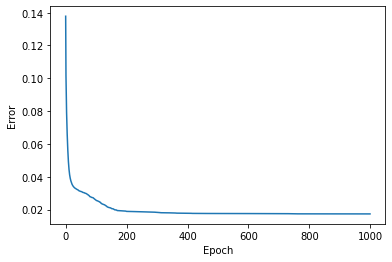

In [48]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

#Recommendation
Choose one user to see what your system would reommend to him based on what he/she already watced and rated. you can change this user to anyuser you would like.
Or even try rate some movies yourself and add yourself as user and see what the system would recommend to you. 


In [49]:
mock_user_id = 215

In [50]:
#Selecting the input user
inputUser = trx[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [51]:
len(inputUser[0])

3706

In [52]:
#Feeding in the user and reconstructing the input
rec = RBM_Model(inputUser)
rec.shape

TensorShape([1, 3706])

In [53]:
# returned all the movies that are rated by users
filt = df_movies['MovieID'].isin(user_rating_df.columns)
scored_movies_df_mock = df_movies[filt]
scored_movies_df_mock

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [54]:
rec.shape

TensorShape([1, 3706])

In [55]:
# add new column contains the predicted values of this user
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
# We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
1726,1784,As Good As It Gets (1997),Comedy|Drama,1.0
907,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical,1.0
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1.0
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1.0
33,34,Babe (1995),Children's|Comedy|Drama,1.0
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure,1.0
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1.0
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,1.0
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1.0
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,1.0


In [56]:
# we can find all the movies that our mock user has watched before
movies_df_mock = df_ratings[df_ratings['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


In [57]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

In [59]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
1618,1784,As Good As It Gets (1997),Comedy|Drama,1.0,NaN,NaN,NaN
858,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical,1.0,NaN,NaN,NaN
466,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1.0,215.0,5.0,976899784.0
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1.0,215.0,5.0,976899190.0
33,34,Babe (1995),Children's|Comedy|Drama,1.0,NaN,NaN,NaN
1108,1198,Raiders of the Lost Ark (1981),Action|Adventure,1.0,NaN,NaN,NaN
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1.0,NaN,NaN,NaN
1449,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,1.0,NaN,NaN,NaN
1025,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1.0,215.0,5.0,976908468.0
1178,1270,Back to the Future (1985),Comedy|Sci-Fi,1.0,NaN,NaN,NaN


#Discuss the results
We can clearly see how our model recommend movies that the user already watched and rated as 5 or 4, this indicates that our model works properly with the un-watched movies before.